# Compare to Hu et al 2009
Hu P, Janga SC, Babu M, Díaz-Mejía JJ, Butland G, Yang W, et al. Global functional atlas of Escherichia coli encompassing previously uncharacterized proteins. PLoS Biol. 2009;7: e96. doi:10.1371/journal.pbio.1000096

In [58]:
import seaborn as sns
import pandas as pd

from yome import Session
from yome.models import *
from yome.util import to_df, report, scale_color, mpl_setup
from yome.constants import colors, hatches_by_number

%mpl_setup

sns.set_style('ticks')

session = Session()

Populating the interactive namespace from numpy and matplotlib


In [43]:
columns = {
#     'Gene': 'primary_name',
    'Bnumber': 'locus_tag',
    'Category': 'hu2009_category',
}

In [51]:
# Load data from Table S1
df = pd.read_table('../sources/hu2009/table-s1-orphans.tsv.gz', compression='gzip').rename(columns=columns)
df = df.loc[:, df.columns.isin(columns.values())]
df.hu2009_category = df.hu2009_category.map(lambda x: 'high' if x == 'annotated' else 'low')

In [52]:
df.hu2009_category.value_counts()

high    2794
low     1431
Name: hu2009_category, dtype: int64

In [53]:
# Load y-ome

In [54]:
yome_genes = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.annotation_quality)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'Y-ome')
).rename(columns={'locus_id': 'locus_tag'})

In [55]:
yome_genes.merge(df)

,locus_tag,annotation_quality,hu2009_category
0,b0001,high,high
1,b0002,high,high
2,b0003,high,high
3,b0004,high,high
4,b0005,low,low
5,b0006,low,low
6,b0007,low,low
7,b0008,high,high
8,b0009,high,high
9,b0010,high,low


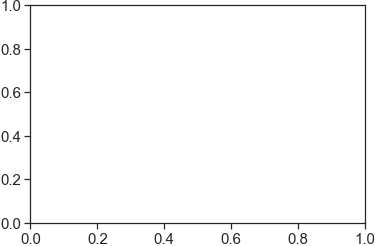

In [60]:
def make_bars(df_all, labels):
    df = df_all[labels].sort_values(by=labels)
    # create bars based on consecutive colors
    last_value = {kbase: None for kbase in labels}
    bars = {kbase: [] for kbase in labels}
    for locus_tag, row in df.iterrows():
        for kbase, value in row.iteritems():
            if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
                bars[kbase].append({'value': value, 'height': 1})
                last_value[kbase] = value
            else:
                bars[kbase][-1]['height'] += 1
    return [bars[x] for x in labels]
def plot_bars(bars, labels, figsize=(13, 11), text=False):
    fig, ax = plt.subplots(figsize=figsize)
    last_heights = [0 for _ in labels]
    for bar_list in it.zip_longest(*bars):
        left = [x + 0.1 for x in range(len(labels))]
        height = [x['height'] if x is not None else 0 for x in bar_list]
        bottom = last_heights
        last_heights = [x + y for x, y in zip(height, last_heights)]
        color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
        hatch = [hatches[x['value']] if x is not None else '' for x in bar_list]
        for l, h, b, c, ha in zip(left, height, bottom, color, hatch):
            ax.bar(l, h, bottom=b, color=c, hatch=ha, edgecolor=scale_color(c, 1.1))
        if text:
            for l, h, b in zip(left, height, bottom):
                if h > 0 and h < 50:
                    y = h / 2 + b
                    ax.annotate(h, xy=(l + 0.15, y), xytext=(l + 0.45, y + 120),
                                arrowprops=dict(facecolor='black', width=1, headwidth=7),
                                verticalalignment='center',
                                color=(0.2,0.2,0.2))
                elif h > 50:
                    y = h + b - (110 if h > 120 else 80 if h > 100 else 30)
                    ax.text(l, y, str(h), horizontalalignment='center', 
                            color=(0.2,0.2,0.2))
    ax.set_xlabel('Knowledgebase')
    ax.set_ylabel('Gene')
    ax.xaxis.set_ticks([x + 0.1 for x in range(len(labels))])
    ax.xaxis.set_ticklabels(labels)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    return fig, ax

labels = ['EcoCyc', 'EcoGene', 'UniProt', 'RegulonDB', 'Manual', 'y-ome']
kbase_bars = make_bars(kbases_plot, labels)
fig, _ = plot_bars(kbase_bars, labels)
fig.savefig('/Users/zaking/lab/y-ome/figs/kbase-bars.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/kbase-bars.png')

In [ ]:
fig, ax = plt.subplots()
for col in 'annotation_quality', 'hu2009_category':
    
ax.bar(l, h, bottom=b, color=c, hatch=ha, edgecolor=scale_color(c, 1.1))